# Getting started with spike-field coherence

***

# On-ramp: compute the spike-field cohernece


Run the code below to load in spike and field data, and compute the spike-field coherence.

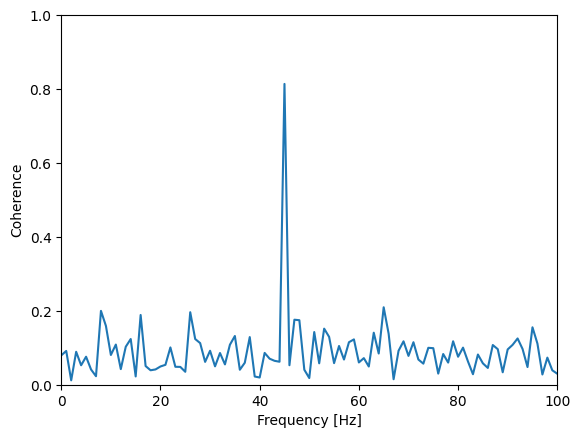

In [1]:
import scipy.io as io
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib tk

# Load the data and plot it.
data = io.loadmat('spikes-LFP-1.mat')       # Load the multiscale data,
y = data['y']                                # ... get the LFP data,
n = data['n']                                # ... get the spike data,
t = data['t'].reshape(-1)                    # ... get the time axis,
K = np.shape(n)[0]                           # Get the number of trials,
N = np.shape(n)[1]                           # ... and the number of data points in each trial,
dt = t[1]-t[0]                               # Get the sampling interval.

SYY = np.zeros(int(N/2+1))                                       # Variable to store field spectrum. autospectrum of Y
SNN = np.zeros(int(N/2+1))                                       # Variable to store spike spectrum. autospectrum of N
SYN = np.zeros(int(N/2+1), dtype=complex)                        # Variable to store cross spectrum. cross-spectrum of Y and N 

for k in np.arange(K):                                           # For each trial,
    yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
    nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
    SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
    SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
    SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

cohr = np.abs(SYN) / np.sqrt(SYY) / np.sqrt(SNN)                 # Spike-field coherence the cross-spectrum divided by the autospectra, then plot (coherence squared)
f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting

plt.plot(f,cohr)                             # Plot the result. Plotting the coherence
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

We have wiggly signal - what does this mean?

If these were two fields and you saw this coherence - what does this mean? They have the same dominant frequency and a constant phase relationship across trials 

***

# Dependence on rate (Part 1)

### For convenience, make a function to compute the cohernece.

In [2]:
def coherence(n,y,t):                           #INPUT (spikes, fields, time)
    K = np.shape(n)[0]                          #... where spikes and fields are arrays [trials, time]
    N = np.shape(n)[1]
    T = t[-1]
    SYY = np.zeros(int(N/2+1))
    SNN = np.zeros(int(N/2+1))
    SYN = np.zeros(int(N/2+1), dtype=complex)
    
    for k in np.arange(K):
        yf = np.fft.rfft((y[k,:]-np.mean(y[k,:])) *np.hanning(N))    # Hanning taper the field,
        nf = np.fft.rfft((n[k,:]-np.mean(n[k,:])))                   # ... but do not taper the spikes.
        SYY = SYY + ( np.real( yf*np.conj(yf) ) )/K                  # Field spectrum
        SNN = SNN + ( np.real( nf*np.conj(nf) ) )/K                  # Spike spectrum
        SYN = SYN + (          yf*np.conj(nf)   )/K                  # Cross spectrum

    cohr = np.abs(SYN) / np.sqrt(SYY) / np.sqrt(SNN)                 # Coherence
    f = np.fft.rfftfreq(N, dt)                                       # Frequency axis for plotting
    
    return (cohr, f, SYY, SNN, SYN)

Let's try it:

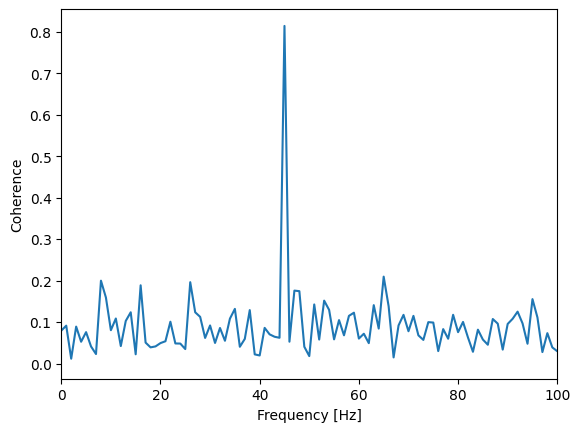

In [3]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)
plt.plot(f,cohr)
plt.xlim([0, 100]); plt.xlabel('Frequency [Hz]'); plt.ylabel('Coherence');

### Make a function to thin a spike train.

Thinning the spike train, it defines the size of the spike times by figuring out the number of spikes(?) then making random spikes then removing a random number of them, setting them equal to 0, then returning then for every single trial 

In [4]:
def thinned_spike_train(n, thinning_factor):              # Thin the spike train (n) by the thinning_factor.
    n_thinned = np.copy(n)                                # Make a copy of the spike train data.
    for k in np.arange(K):                                # For each trial,
        spike_times = np.where(n[k,:]==1)                 # ...find the spikes.
        n_spikes = np.size(spike_times)                   # ...determine number of spikes.
        spike_times_random = spike_times[0][np.random.permutation(n_spikes)]    # ...permute spikes indices,
        n_remove=int(np.floor(thinning_factor*n_spikes))  # ... determine number of spikes to remove,
        n_thinned[k,spike_times_random[1:n_remove]]=0     # remove the spikes.
    return n_thinned

Let's try it:

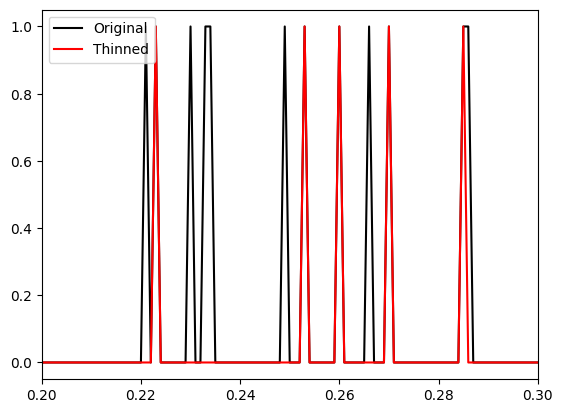

In [5]:
plt.clf()
plt.plot(t, n[0,:], 'k')
plt.plot(t, thinned_spike_train(n,0.5)[0,:], 'r');
plt.xlim([0.2, 0.3])
plt.legend(['Original', 'Thinned']);

Does this data look thinned?

I guess what does thin data look like exactly 

### Compare the spike-field coherence for original and thinned data.

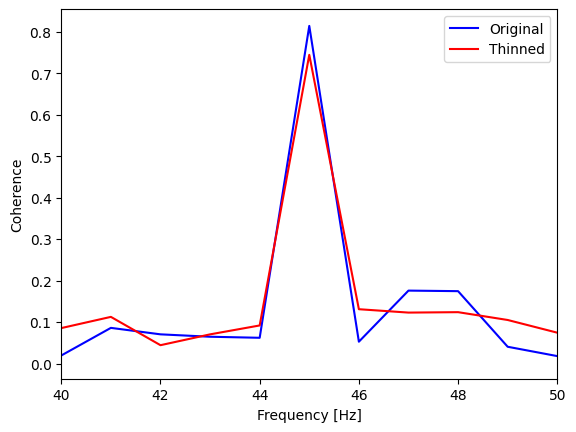

In [6]:
[cohr, f, SYY, SNN, SYN] = coherence(n,y,t)                          # Coherence for original spike train.
plt.clf()
plt.plot(f,cohr, 'b')
[cohr, f, SYY, SNN, SYN] = coherence(thinned_spike_train(n,0.5),y,t) # ... and for the thinned spike train.
plt.plot(f,cohr, 'r')
plt.xlim([40, 50])
plt.legend(['Original', 'Thinned'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

### Repeat for different thinning factors.

<Figure size 640x480 with 0 Axes>

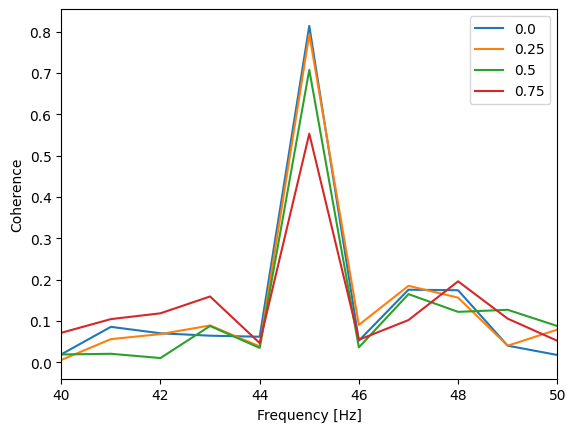

In [7]:
plt.figure(1); plt.clf(); plt.figure(2); plt.clf()
counter=1
for thinner in np.arange(0,1,0.25):
    thinned = thinned_spike_train(n,thinner)
    [cohr, f, SYY, SNN, SYN] = coherence(thinned,y,t) # ... and for the thinned spike train.
    plt.figure(1)
    plt.plot(f,cohr,label=str(thinner))
    
plt.figure(1)
plt.xlim([40, 50])
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

As you get rid of more spikes you are reducing their spike field coherence. Can you compare two neurons with different 

Q: Does the spike-field coherence depend on the firing rate of the neuron?

Observations: greater thinning = fewer spikes = lower coherence

as the rate tends to 00, so does the spike-field coherence

Q: So what next: if your spike rate differences between two neurons, how do you compare the spike-field coherence?

A: a rate adjustment factor in coherencce measure to account for rate dependece, or build a generalized linear model to seperate overall neural activity from spike train-LFP oscillatory coupling. 

***

# Dependence on rate (Part 2)

### Simulate two simple spiking neurons, with activity dependent on a field.

In [ ]:
def sim_two_neurons(baseline_rate_A, baseline_rate_B, field_coupling_A, field_coupling_B):
    K = 100                            # Number of trials.
    N = 1000                           # Points per trial.
    A = np.zeros([K,N])                # Array to hold spikes A.
    B = np.zeros([K,N])                # Array to hold spikes B.
    y = np.zeros([K,N])                # Array to hold field.
    for k in np.arange(K):             # For each trial,
        y[k,:] = np.sin(2*np.pi*t*10) + 0.1*np.random.randn(N)    # ... generate a field,
        A[k,:] = np.random.binomial(1,0.001*np.exp(baseline_rate_A+field_coupling_A*y[k,:]))      # ... generate spikes #A that depend on the field,
        B[k,:] = np.random.binomial(1,0.001*np.exp(baseline_rate_B+field_coupling_B*y[k,:]))      # ... generate spikes #B that depend on the field.
    return A,B,y

### Visualize example trials.

In [ ]:
plt.clf()
rate_A = 1.0;  coupling_A = 0.5             # Fix the rates and coupling to field for each neuron.
rate_B = 1.0;  coupling_B = 0.5             # Simulate the two neurons.
A,B,y = sim_two_neurons(rate_A, rate_B, coupling_A, coupling_B)
n_trial = 0;                                # Select a trial to plot.
plt.plot(t,A[n_trial,:])
plt.plot(t,B[n_trial,:])
plt.plot(t,y[n_trial,:])
plt.legend(["Neuron A", "Neuron B", "Field"]);

### Compute the average rate of each neuron

In [ ]:
rateA = np.mean(sum(A,1)/t[-1])
rateB = np.mean(sum(B,1)/t[-1])

print("A(Rate) = ", rateA, ", B(Rate) = ", rateB)

### Compute the spike-field coherence.

In [ ]:
plt.clf()

[cohr, f, SYY, SNN, SYN] = coherence(A,y,t); plt.plot(f,cohr)

[cohr, f, SYY, SNN, SYN] = coherence(B,y,t); plt.plot(f,cohr)

plt.xlim([0,20])
plt.ylim([0,1])
plt.legend(['Neuron A', 'Neuron B'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');

### Repeat coherence calculation for many realizations

In [ ]:
baseline_A = 1.0;  coupling_A = 1.0   # Fix the rates and coupling to field for each neuron.
baseline_B = 1.0;  coupling_B = 0.5
cohr_A = np.zeros([501,100])
cohr_B = np.zeros([501,100])
for k in np.arange(100):              # For 100 realizations, simulate the neurons & compute coherence.
    A,B,y = sim_two_neurons(baseline_A, baseline_B, coupling_A, coupling_B)
    [cohr, f, SYY, SNN, SYN] = coherence(A,y,t); cohr_A[:,k] = cohr
    [cohr, f, SYY, SNN, SYN] = coherence(B,y,t); cohr_B[:,k] = cohr

In [ ]:
# Plot the coherence results.
plt.clf()
mn = np.mean(cohr_A,1); se = np.std( cohr_A,1)/np.sqrt(np.shape(cohr_A)[1])
plt.plot(f,mn,'b',label="Neuron A"); plt.plot(f,mn-2*se, 'b:'); plt.plot(f,mn+2*se, 'b:');
mn = np.mean(cohr_B,1); se = np.std( cohr_B,1)/np.sqrt(np.shape(cohr_B)[1])
plt.plot(f,mn,'r',label="Neuron B"); plt.plot(f,mn-2*se, 'r:'); plt.plot(f,mn+2*se, 'r:');
plt.xlim([5,15]); plt.ylim([0,1]);
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence');
plt.title('Neuron A Rate: Baseline=' + str(baseline_A) + ', Coupling=' + str(coupling_A) + '\n'
          'Neuron B Rate: Baseline=' + str(baseline_B) + ', Coupling=' + str(coupling_B));